In [2]:
import pandas as pd

# Load the geospatial dataset "Census_geo_data.csv"
file_path = '/content/Census_geo_data.csv'
census_geo_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure and contents
census_geo_data.head()

,STATEFP_x,COUNTYFP_x,TRACTCE_x,BLKGRPCE_x,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area,GEOID_12
0,48,201,341700,3,1500000US482013417003,482013417003,3,BG,588536,2329,...,-99999.000000,-99999.000000,9,4,9,1,5.500000,4606.004701,5.908648e+05,482013417003
1,48,37,10901,2,1500000US480370109012,480370109012,2,BG,5976489,137294,...,-99999.000000,-99999.000000,19,17,7,1,8.666667,11345.670980,6.113782e+06,480370109012
2,48,427,950204,2,1500000US484279502042,484279502042,2,BG,3752003,67429,...,-99999.000000,-99999.000000,14,1,6,1,4.833333,11670.005580,3.819429e+06,484279502042
3,48,113,13101,2,1500000US481130131012,481130131012,2,BG,761546,0,...,0.000365,0.105555,3,6,13,13,10.166667,3693.258885,7.615446e+05,481130131012
4,48,245,7100,2,1500000US482450071002,482450071002,2,BG,3473239,20518,...,-99999.000000,-99999.000000,3,14,8,1,5.833333,9522.893993,3.493759e+06,482450071002


In [3]:
census_geo_data.geometry[:5]

0    POLYGON ((-95.018841 29.645951999999998, -95.0...
1    POLYGON ((-94.074631 33.486134, -94.071851 33....
2    POLYGON ((-98.96742599999999 26.401041, -98.96...
3    POLYGON ((-96.788231 32.901438, -96.788062 32....
4    POLYGON ((-94.032049 29.901871, -94.009638 29....
Name: geometry, dtype: object

In [5]:
from types import new_class
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, shape
from shapely import wkt
from tqdm import tqdm

def generate_random_points(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < num_points:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        random_point = Point(x, y)
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Load your dataset
census_geo_data = pd.read_csv('/content/Census_geo_data.csv')

# Convert the geometry column to shapely Polygon objects
census_geo_data['geometry'] = census_geo_data['geometry'].apply(lambda x: shape(wkt.loads(x)))

# Create a GeoDataFrame for polygons
gdf_poly = gpd.GeoDataFrame(census_geo_data, geometry='geometry')

# Initialize an empty list to store the new data
new_data = []

# Loop through each polygon
for _, row in tqdm(gdf_poly.iterrows(), total=gdf_poly.shape[0]):
    polygon = row['geometry']
    geoid = row['GEOID_12']
    points = generate_random_points(polygon, 100)
    new_data.extend([{'geometry': polygon, 'GEOID_12': geoid, 'point': point} for point in points])

# Convert the list of dictionaries to a DataFrame
new_points_df = pd.DataFrame(new_data)

# Display the first few rows of the new DataFrame
new_points_df.head()


100%|██████████| 15800/15800 [02:10<00:00, 121.48it/s]


,geometry,GEOID_12,point
0,"POLYGON ((-95.018841 29.645951999999998, -95.0...",482013417003,POINT (-95.01691150450588 29.635467975032114)
1,"POLYGON ((-95.018841 29.645951999999998, -95.0...",482013417003,POINT (-95.01391822301285 29.629960231116076)
2,"POLYGON ((-95.018841 29.645951999999998, -95.0...",482013417003,POINT (-95.0169704759122 29.6412211404041)
3,"POLYGON ((-95.018841 29.645951999999998, -95.0...",482013417003,POINT (-95.01552890123347 29.63655059362176)
4,"POLYGON ((-95.018841 29.645951999999998, -95.0...",482013417003,POINT (-95.0171399261246 29.638101329455843)


In [6]:
new_points_df.shape

(1580000, 3)

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
new_points_df.to_pickle('/content/new_points_df.pkl')


100%|██████████| 2/2 [06:35<00:00, 197.76s/it]


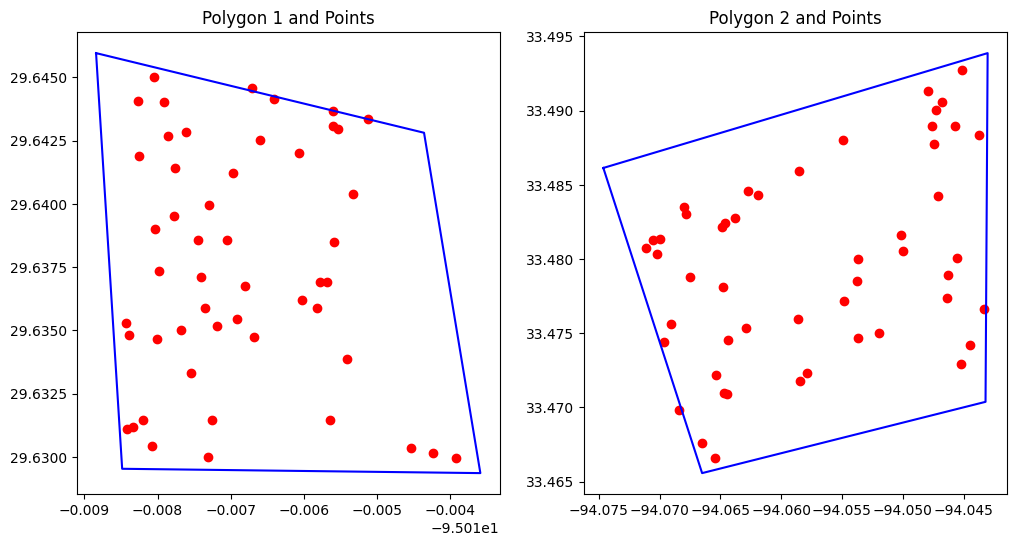

In [14]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Further simplify polygons for faster plotting
new_points_df['simplified_geometry'] = new_points_df['geometry'].apply(lambda x: x.simplify(0.05))  # Increase the tolerance

# Get the unique simplified polygons (first two)
unique_polygons = new_points_df['simplified_geometry'].unique()[:2]

# Prepare the figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Loop through the first two unique polygons
for i, polygon in tqdm(enumerate(unique_polygons), total=len(unique_polygons)):
    # Filter points for the current polygon
    points = new_points_df[new_points_df['simplified_geometry'] == polygon]['point']

    # Reduce the number of points if there are too many
    if len(points) > 50:  # Further reduce the number of points if needed
        points = points.sample(50)

    # Plot the polygon
    axs[i].plot(*polygon.exterior.xy, color='blue')

    # Plot the points
    x_coords = [point.x for point in points]
    y_coords = [point.y for point in points]
    axs[i].scatter(x_coords, y_coords, color='red')

    axs[i].set_title(f"Polygon {i+1} and Points")

plt.show()
